In [14]:
import torch 
import torch.nn as nn 
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from dataset import get_loaders
from models.tranad import TranAD

In [20]:
DEVICE="mps"
WINDOW=10
BATCH_SIZE=32
LR=1e-3
EPOCHS=5

In [18]:
trainloader, testloader = get_loaders(root='data', window_size=WINDOW, batch_size=BATCH_SIZE)

In [27]:
model = TranAD(in_dim=123, window=WINDOW).to(DEVICE)

/Users/samyvilhes/anaconda3/envs/these/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(


In [28]:
optimizer = optim.AdamW(model.parameters() , lr=LR, weight_decay=1e-5)
criterion = nn.MSELoss(reduction="none")
scheduler = optim.lr_scheduler.StepLR(optimizer, 5, 0.9)

In [34]:
pbar = range(EPOCHS)
for epoch in pbar:
    epoch_loss=0

    for x, target in tqdm(trainloader):
        x = x.to(DEVICE).permute(1, 0, 2)
        elem = x[-1, :, :].view(1, x.size(1), x.size(2))
        x1, x2 = model(x, elem)
        loss = 1/(epoch+1) * criterion(elem, x1) + (1 - 1/(epoch+1)) * criterion(elem, x2)
        loss = torch.sum(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss+=loss.item()
        break
    print(f"Training loss: {epoch_loss/len(trainloader)}")
    scheduler.step()
    break

checkpoint = {"state_dict":model.state_dict()}
torch.save(checkpoint, 'checkpoints/tranad.pkl')

  0%|          | 0/24518 [00:00<?, ?it/s]

Training loss: 0.4172058379302961


In [30]:
test_loss = []
labels = []

model.eval()
with torch.no_grad():
    for x, label in tqdm(testloader):
        x = x.to(DEVICE).permute(1, 0, 2)
        elem = x[-1, :, :].view(1, x.size(1), x.size(2))
        _, pred = model(x, elem)
        error = criterion(pred, elem).permute(1, 0, 2)
        error = torch.mean(error, dim=(1, 2))
        test_loss.append(error)
        labels.append(label)

test_loss = torch.cat(test_loss)
test_scores = - test_loss.cpu()

test_targets = torch.cat(labels)

100%|██████████| 5400/5400 [00:24<00:00, 221.16it/s]


In [31]:
results = pd.DataFrame({
    "scores":test_scores.cpu(),
    "labels":test_targets.cpu()
})

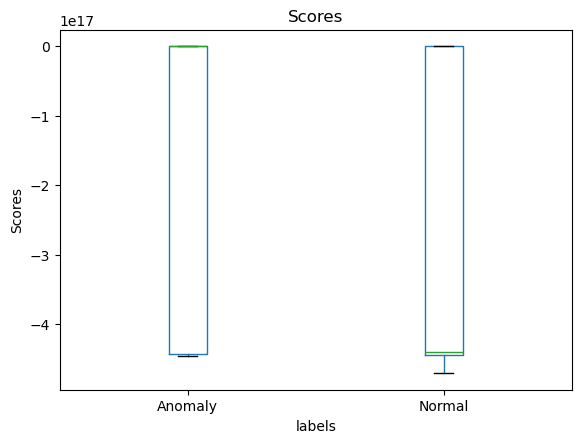

In [32]:
results.boxplot(column='scores', by='labels', grid=False)
plt.title('Scores')
plt.suptitle('')  # Remove the automatic title
plt.xticks(ticks=[1, 2], labels=['Anomaly', 'Normal'])
plt.ylabel('Scores')
plt.show()

In [33]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(test_targets, test_scores)
print("AUC Score: ", round(auc, 3))

AUC Score:  0.486
